## Finilizing Data Generation for 0D Reactor

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

from scipy.integrate import solve_ivp

pd.options.mode.chained_assignment = None  # default='warn'

3.8.11 (default, Jun 29 2021, 03:17:05) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [2]:
### Input Data

OutputDir  = WORKSPACE_PATH+'/ROMNet/Data/0DReact_Isobaric_100Cases_Highest/'
# TestDir    = WORKSPACE_PATH+'/ROMNet/Data/0DReact_Isobaric_100Cases_Test/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass
# try:
#     os.makedirs(TestDir)
# except OSError as e:
#     pass

NVarsRed           = 7

tStratch           = 1.
SOLVER             = 'BDF'

ValidPerc          = 20.

FixedMinVal        = 1.e-14

In [3]:
Vars = []
for iVars in range(1,NVarsRed+1):
    Vars.append('PC_'+str(iVars))

Vars0 = []
for iVars in range(1,NVarsRed+1):
    Vars0.append('PC0_'+str(iVars))
    
SVars = []
for iVars in range(1,NVarsRed+1):
    SVars.append('SPC_'+str(iVars))
    

FileName     = OutputDir + '/Orig/train/ext/SimIdxs.csv'
Data         = pd.read_csv(FileName, header=0)
SimIdxs      = Data.to_numpy(int)


FileName     = OutputDir + '/Orig/train/ext/ICs.csv'
Data         = pd.read_csv(FileName)
ICVecs       = Data.to_numpy()
NICs         = len(ICVecs)


P0Vec        = []
EqRatio0Vec  = []
T0Vec        = []
for iC in range(NICs):
    Nts      = SimIdxs[iC,1]-SimIdxs[iC,0]
    P0Vec.append(       np.ones(Nts, dtype=np.float64)*ICVecs[iC,0])
    EqRatio0Vec.append( np.ones(Nts, dtype=np.float64)*ICVecs[iC,1])
    T0Vec.append(       np.ones(Nts, dtype=np.float64)*ICVecs[iC,2])
P0Vec        = np.concatenate(P0Vec)[...,np.newaxis]
EqRatio0Vec  = np.concatenate(EqRatio0Vec)[...,np.newaxis]
T0Vec        = np.concatenate(T0Vec)[...,np.newaxis]


# for iC in range(NICs):
#     Nts              = SimIdxs[iC,1]-SimIdxs[iC,0]
#     FileName         = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iC+1)
#     DataTemp         = pd.read_csv(FileName, header=0)
#     DataTemp         = DataTemp[DataTemp['t'] == 0.][Vars]
#     DataTemp         = DataTemp.loc[DataTemp.index.repeat(Nts)]
#     if (iC==0):
#         Data0        = DataTemp
#     else:
#         Data0        = pd.concat([Data0, DataTemp], axis=0)
# Data0.columns = Vars0
# Data0.reset_index(drop=True, inplace=True)
for iC in range(NICs):
    Nts              = SimIdxs[iC,1]-SimIdxs[iC,0]
    FileName         = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iC+1)
    DataTemp         = pd.read_csv(FileName, header=0)
    DataTemp         = DataTemp.iloc[[1]][Vars]#DataTemp.iloc[1][Vars]
    DataTemp         = DataTemp.loc[DataTemp.index.repeat(Nts)]
    if (iC==0):
        Data0        = DataTemp
    else:
        Data0        = pd.concat([Data0, DataTemp], axis=0)
Data0.columns = Vars0
Data0.reset_index(drop=True, inplace=True)

In [4]:
### Retrieving Data
    
FileName             = OutputDir + '/Orig/train/ext/t.csv'
Data                 = pd.read_csv(FileName, header=None)
tVec                 = Data.to_numpy()[:,0]
tVec                 = [tVec[i] if tVec[i] > FixedMinVal else FixedMinVal for i in range(len(tVec))]

FileName             = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv'
Data                 = pd.read_csv(FileName, header=0)
Data[Vars0]          = Data0
Data['t']            = tVec
Data['log(t)']       = np.log(tVec)
Data['log10(t)']     = np.log10(tVec)
Data['Phi0']         = EqRatio0Vec
Data['T0']           = T0Vec
Data['P0']           = P0Vec
yMat_pca             = Data[Vars].to_numpy()

FileName             = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PCSource.csv'
DataS                = pd.read_csv(FileName, header=0)
DataS[Vars0]         = Data0
DataS['t']           = tVec
DataS['log(t)']      = np.log(tVec)
DataS['log10(t)']    = np.log10(tVec)
DataS['Phi0']        = EqRatio0Vec
DataS['T0']          = T0Vec
DataS['P0']          = P0Vec
ySource_pca          = DataS[SVars].to_numpy()


### Writing Input
InputVar     = ['t', 'log10(t)', 'log(t)', 'T0', 'P0', 'Phi0'] + Vars0
DataInput    = Data[InputVar]
DataInput.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/ext/Input.csv', index=False)
tVec         = DataInput.t.to_numpy()


### Writing PCs
Data.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/ext/Output.csv', index=False)


### Normalizing PCs' Source Terms
yMax         = ySource_pca.max(0)
yMin         = ySource_pca.min(0)
yRange       = (yMax-yMin)
yScale       = np.concatenate([yMin[...,np.newaxis], yMax[...,np.newaxis]], axis=1)
np.savetxt(OutputDir+'/'+str(NVarsRed)+'PC/train/ext/MinMax.csv', yScale, header='Min,Max', comments='', delimiter=',')

ySourcee_pca = (ySource_pca - yMin)/yRange
#ySourcee_pca = (ySource_pca - yMin)/yRange[0]

for iPC in range(NVarsRed):
    DataS['SPC_'+str(iPC+1)+'_Scaled'] = ySourcee_pca[:,iPC]
DataS.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/ext/dOutput.csv', index=False)

In [5]:
Data

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC0_1,PC0_2,PC0_3,PC0_4,PC0_5,PC0_6,PC0_7,t,log(t),log10(t),Phi0,T0,P0
0,-30.032977,0.296754,0.284795,-0.008057,0.014365,0.006430,-0.003945,-30.033690,0.296726,0.284768,-0.008075,0.014363,0.006419,-0.003963,1.000000e-14,-32.236191,-14.000000,2.6175,1675.0,101325.0
1,-30.033690,0.296726,0.284768,-0.008075,0.014363,0.006419,-0.003963,-30.033690,0.296726,0.284768,-0.008075,0.014363,0.006419,-0.003963,1.202318e-06,-13.631259,-5.919981,2.6175,1675.0,101325.0
2,-30.033696,0.296725,0.284767,-0.008075,0.014363,0.006419,-0.003964,-30.033690,0.296726,0.284768,-0.008075,0.014363,0.006419,-0.003963,1.215886e-06,-13.620037,-5.915107,2.6175,1675.0,101325.0
3,-30.033702,0.296725,0.284767,-0.008075,0.014363,0.006419,-0.003964,-30.033690,0.296726,0.284768,-0.008075,0.014363,0.006419,-0.003963,1.229608e-06,-13.608815,-5.910233,2.6175,1675.0,101325.0
4,-30.033708,0.296724,0.284766,-0.008075,0.014363,0.006419,-0.003964,-30.033690,0.296726,0.284768,-0.008075,0.014363,0.006419,-0.003963,1.243485e-06,-13.597593,-5.905359,2.6175,1675.0,101325.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,8.931632,-0.200213,0.100233,0.056094,0.006470,-0.031541,-0.007269,-43.949692,0.101555,0.217137,-0.028391,-0.018173,-0.015756,0.026225,7.485911e-03,-4.894733,-2.125755,3.0025,1365.0,101325.0
99996,8.931536,-0.200213,0.100234,0.056092,0.006458,-0.031543,-0.007272,-43.949692,0.101555,0.217137,-0.028391,-0.018173,-0.015756,0.026225,7.535904e-03,-4.888076,-2.122865,3.0025,1365.0,101325.0
99997,8.931440,-0.200213,0.100234,0.056090,0.006445,-0.031545,-0.007274,-43.949692,0.101555,0.217137,-0.028391,-0.018173,-0.015756,0.026225,7.586231e-03,-4.881420,-2.119974,3.0025,1365.0,101325.0
99998,8.931344,-0.200213,0.100235,0.056088,0.006433,-0.031547,-0.007277,-43.949692,0.101555,0.217137,-0.028391,-0.018173,-0.015756,0.026225,7.636894e-03,-4.874764,-2.117083,3.0025,1365.0,101325.0


Text(0.5, 0, '$dPC_3/dt$')

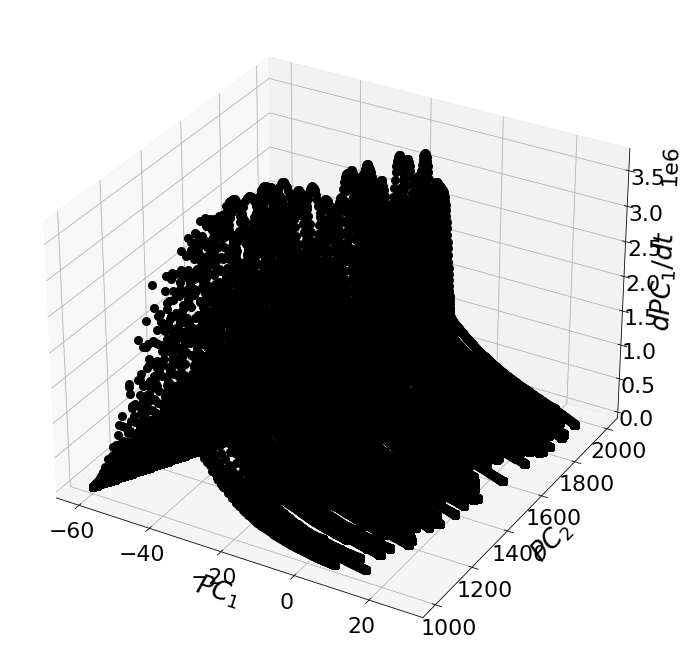

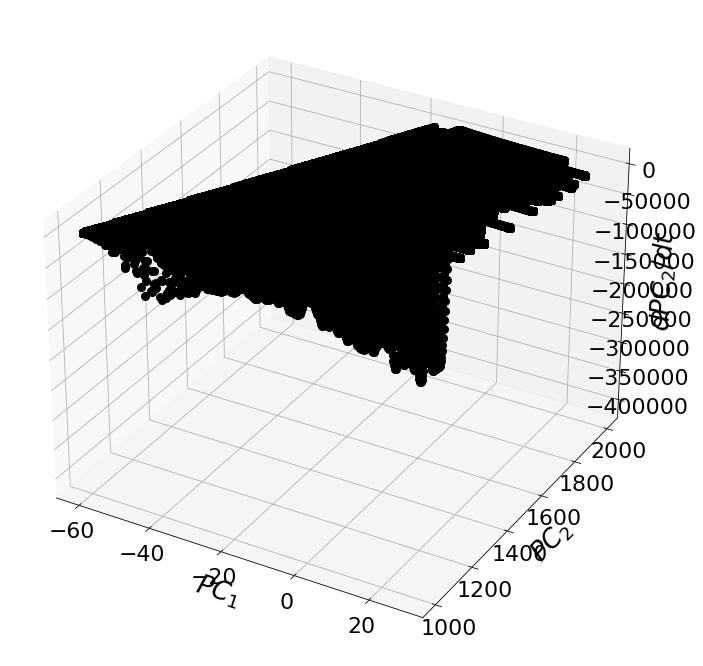

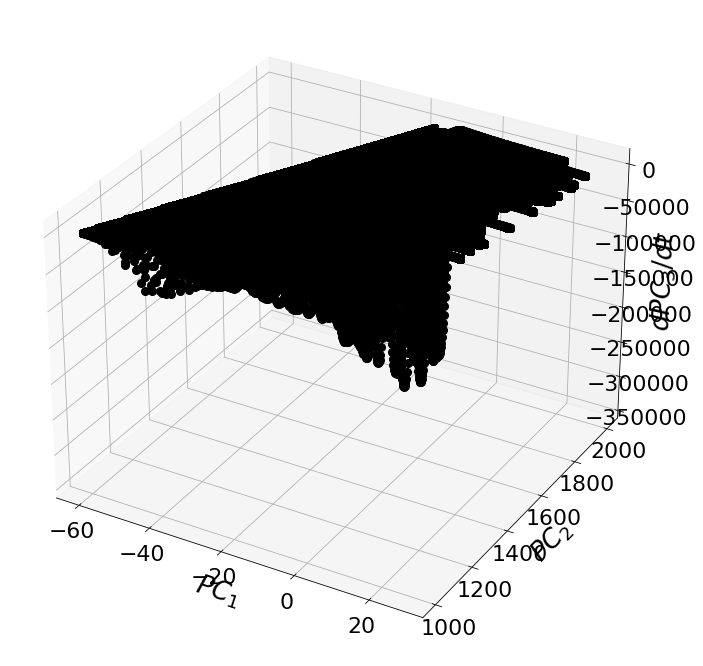

In [6]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], T0Vec, ySource_pca[:,0], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_1/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], T0Vec, ySource_pca[:,1], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_2/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat_pca[:,0], T0Vec, ySource_pca[:,2], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_3/dt$')

Text(0.5, 0, '$dPC_3/dt$')

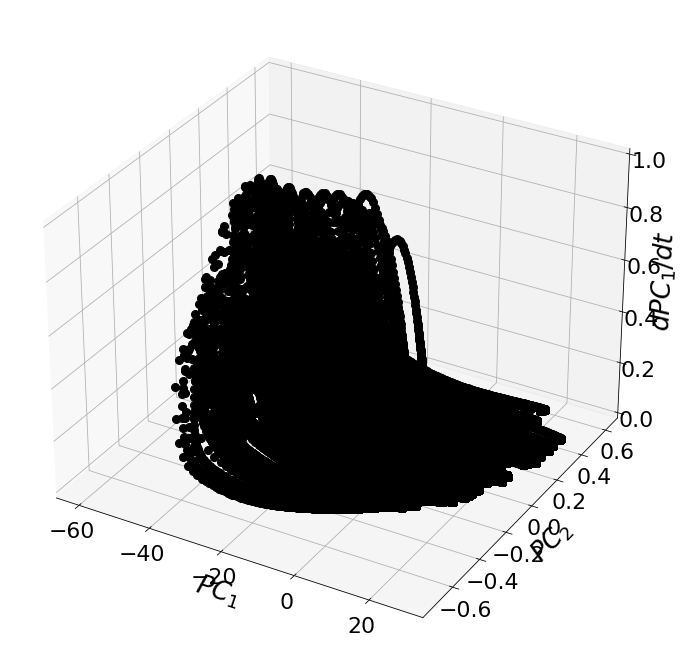

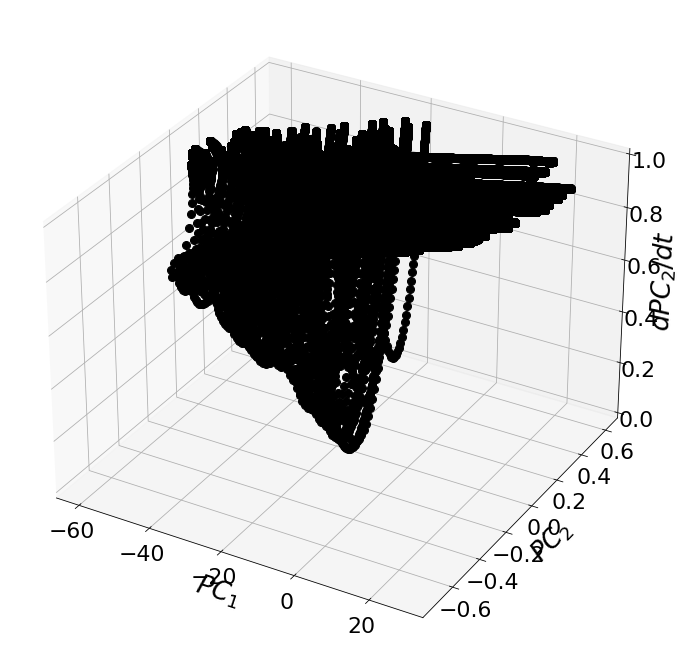

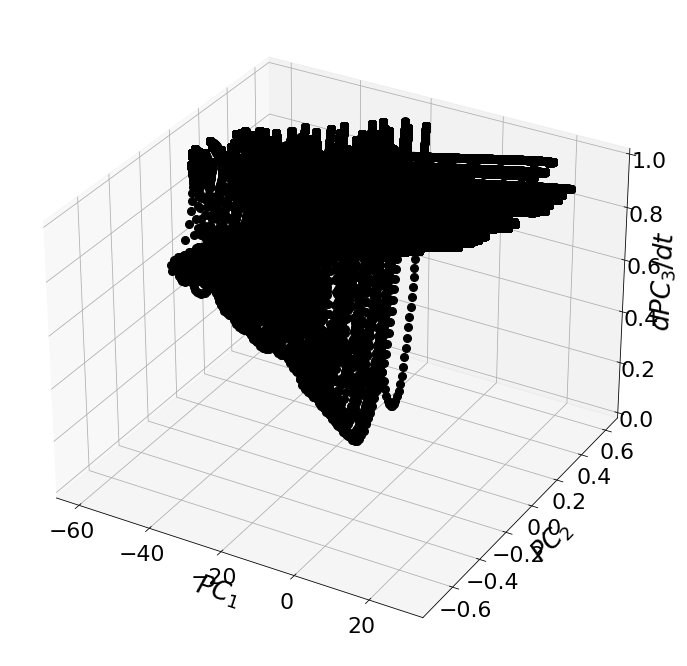

In [7]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMat_pca[:,0], yMat_pca[:,1], ySourcee_pca[:,0], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_1/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMat_pca[:,0], yMat_pca[:,1], ySourcee_pca[:,1], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_2/dt$')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D( yMat_pca[:,0], yMat_pca[:,1], ySourcee_pca[:,2], 'ok',  linewidth=2)
ax.set_xlabel(r'$PC_1$')
ax.set_ylabel(r'$PC_2$')
ax.set_zlabel(r'$dPC_3/dt$')

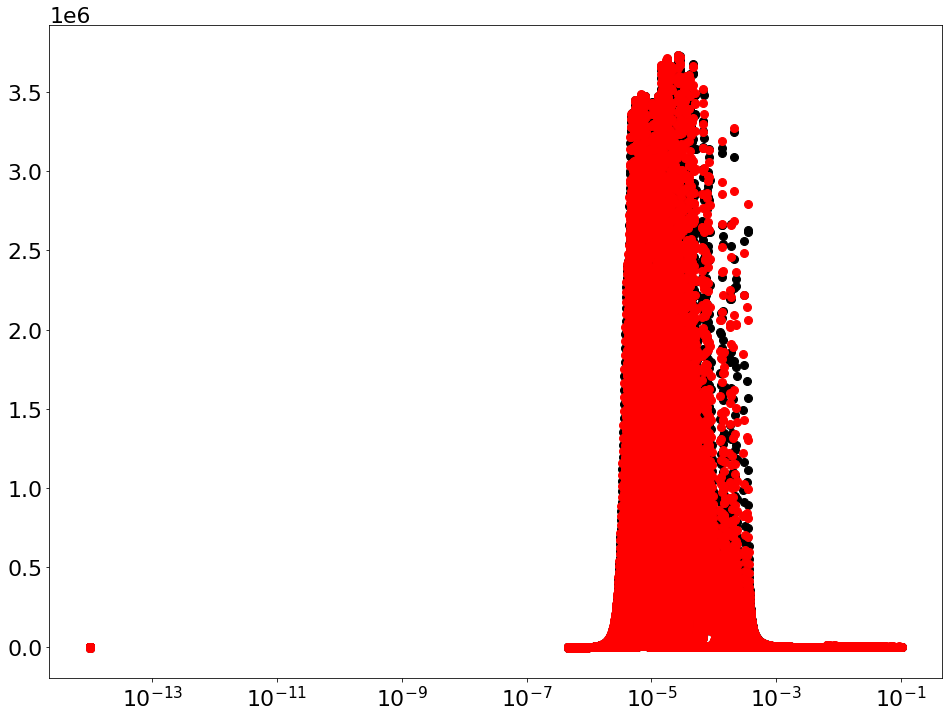

In [8]:
### Checking Data

from numpy import diff

iPC = 0

dydt = diff(yMat_pca[:,iPC])/diff(tVec)

fig = plt.figure(figsize=(16,12))
plt.plot(tVec, ySource_pca[:,iPC], 'ko')
plt.plot(tVec[0:-1], dydt, 'ro')
plt.xscale('log')

In [9]:
from sklearn.model_selection import train_test_split

DataNoZero           = Data[Data['t'] > FixedMinVal]
n_points             = len(DataNoZero)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=ValidPerc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/valid/')
except:
    pass

In [10]:
data_id    = 'pts'

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/')
except:
    pass

DataInput  = DataNoZero[InputVar]
DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Input.csv', index=False)

DataOutput = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataOutput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Output.csv', index=False)

In [11]:
data_id    = 'res'

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/')
except:
    pass

DataInput        = DataNoZero[InputVar]
DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Input.csv', index=False)

DataOutput       = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataOutput[Vars] = DataOutput[Vars].to_numpy() * 0.
DataOutput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Output.csv', index=False)

In [12]:
data_id = 'ics'

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/')
except:
    pass

Data_ics                     = Data[Data['t'] == FixedMinVal]
n_points_ics                 = len(Data_ics)
idx_ics                      = np.arange(n_points_ics)
train_idx_ics, valid_idx_ics = train_test_split(idx_ics, test_size=ValidPerc/100, random_state=41)

DataInput      = Data_ics[InputVar]
DataInput.iloc[train_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Input.csv', index=False)

DataOutput       = Data_ics[['t', 'log10(t)', 'log(t)'] + Vars]
DataOutput.iloc[train_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Output.csv', index=False)

In [13]:
data_id = 'scs'

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/')
except:
    pass

Mask                         = [i for i in range(1,len(Data)-1) if Data.iloc[i-1]['t'] == FixedMinVal]
Data_ics                     = Data.iloc[Mask]
n_points_ics                 = len(Data_ics)
idx_ics                      = np.arange(n_points_ics)
train_idx_ics, valid_idx_ics = train_test_split(idx_ics, test_size=ValidPerc/100, random_state=41)

DataInput      = Data_ics[InputVar]
DataInput.iloc[train_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Input.csv', index=False)

DataOutput       = Data_ics[['t', 'log10(t)', 'log(t)'] + Vars]
DataOutput.iloc[train_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Output.csv', index=False)

In [14]:
data_id = 'fcs'

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/')
except:
    pass

Mask                         = [i for i in range(-1,len(Data)-1) if Data.iloc[i+1]['t'] == FixedMinVal]
Data_ics                     = Data.iloc[Mask]
n_points_ics                 = len(Data_ics)
idx_ics                      = np.arange(n_points_ics)
train_idx_ics, valid_idx_ics = train_test_split(idx_ics, test_size=ValidPerc/100, random_state=43)

DataInput      = Data_ics[InputVar]
DataInput.iloc[train_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Input.csv', index=False)

DataOutput       = Data_ics[['t', 'log10(t)', 'log(t)'] + Vars]
DataOutput.iloc[train_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx_ics].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/valid/'+data_id+'/Output.csv', index=False)

In [15]:
# ### Retrieving Data

# Vars = []
# for iVars in range(1,NVarsRed+1):
#     Vars.append('PC_'+str(iVars))

# SVars = []
# for iVars in range(1,NVarsRed+1):
#     SVars.append('SPC_'+str(iVars))

# FileName     = TestDir + '/orig_data/RestVecTot.csv'
# Data         = pd.read_csv(FileName, header=None)
# RestVecTot   = np.log10(Data.to_numpy())
    
# # FileName     = TestDir+'/orig_data/t.csv'
# # Data         = pd.read_csv(FileName, header=None)
# # tVec         = Data.to_numpy()[:,0]

# # FileName     = TestDir + '/orig_data/yCleaned.csv'
# # yMatOrig     = pd.read_csv(FileName, header=0)
# # VarNames     = list(yMatOrig.columns)
# # yMat         = yMatOrig.to_numpy()

# FileName             = TestDir+'/'+str(NVarsRed)+'PC/PC.csv'
# Data                 = pd.read_csv(FileName, header=0)
# Data['log10(t)']     = np.log10(Data.t.to_numpy()+1.e-15)
# Data['log10(Rest)']  = RestVecTot
# Data['Rest']         = 10.**RestVecTot
# yMat_pca             = Data[Vars].to_numpy()

# FileName             = TestDir+'/'+str(NVarsRed)+'PC/PCSource.csv'
# DataS                = pd.read_csv(FileName, header=0)
# DataS['log10(t)']    = np.log10(Data.t.to_numpy()+1.e-15)
# DataS['log10(Rest)'] = RestVecTot
# DataS['Rest']        = 10.**RestVecTot
# ySource_pca          = DataS[SVars].to_numpy()


# ### Writing Input
# InputVar     = ['t', 'log10(t)', 'Rest', 'log10(Rest)']
# DataInput    = Data[InputVar]
# DataInput.to_csv(TestDir+'/'+str(NVarsRed)+'PC/Input.csv', index=False)
# tVec         = DataInput.t.to_numpy()


# ### Writing PCs
# Data.to_csv(TestDir+'/'+str(NVarsRed)+'PC/Output.csv', index=False)


# ### Normalizing PCs' Source Terms
# ySourcee_pca = (ySource_pca - yMin)/yRange
# #ySourcee_pca = (ySource_pca - yMin)/yRange[0]

# for iPC in range(NVarsRed):
#     DataS['SPC_'+str(iPC+1)+'_Scaled'] = ySourcee_pca[:,iPC]
# DataS.to_csv(TestDir+'/'+str(NVarsRed)+'PC/dOutput.csv', index=False)